In [8]:
import numpy as np
import scipy.ndimage as sn
import scipy.signal as ss
from scipy.fftpack import fft2, ifft2, fftshift, ifftshift
from skimage import filters
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt
import skimage
from skimage import feature
from skimage.io import imsave
from skimage import morphology as mp
from skimage import transform
import math
from skimage.color import rgb2hsv, hsv2rgb
from skimage.util import random_noise as rn
from PIL.Image import open as imread
from PIL import ImageOps as Iops
import time
import matplotlib
from random import random
import cv2 as cv2

In [2]:
def showG(im, boundaries = False, cmap='gray'):
    if boundaries:
        plt.imshow(im, cmap=cmap, vmin=0, vmax=255)
    else:    
        plt.imshow(im, cmap=cmap)
        plt.colorbar()
    
    return plt.show()
    
def loadIm(im, show = True):
    g = Iops.grayscale(imread(im))
    A = np.array(g)
    if show: showG(A)
    return A


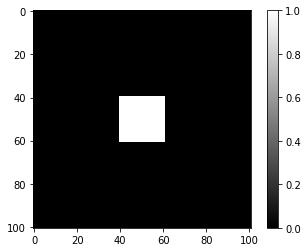

In [91]:
size = 101
square = np.zeros((size,size))
square[size//2-(size//10):size//2+(size//10+1),size//2-(size//10):size//2+(size//10+1)] = 1
showG(square)

In [94]:
def transform_image(im):
    cos = np.cos(2*np.pi - np.pi/10)
    sin = np.sin(2*np.pi - np.pi/10)
    s = 2
    Y,X = im.shape

    T_t = np.array([[1,0,10.4],
                    [0,1,15.7],
                    [0,0,1]])
    T_c = np.array([[1,0,X//2],
                    [0,1,Y//2],
                    [0,0,1]])
    T_c_inv = np.array([[1,0,-X//2],
                        [0,1,-Y//2],
                        [0,0,1]])
    R = np.array([[cos,-sin,0],
                  [sin, cos,0],
                  [0,0,1]])
    S = np.array([[s,0,0],
                  [0,s,0],
                  [0,0,1]])

    t = T_t@T_c@R@S@T_c_inv

    old_im = im
    new_im = np.zeros_like(im)
    for y in range(Y):
        for x in range(X):
            nx, ny, _ = np.dot(np.linalg.inv(t),[x,y,1])
            nx = int(np.round(nx))
            ny = int(np.round(ny))
            new_im[y,x] = old_im[ny,nx]
    return new_im

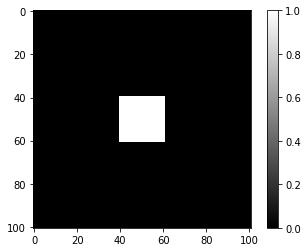

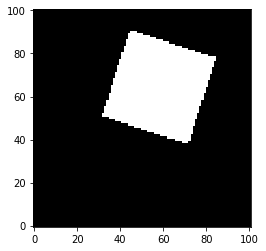

In [95]:
showG(square)
trans = transform_image(square)
plt.imshow(trans, cmap='gray',origin='lower')

In [92]:
def transform_test(im):
    cos_inv = np.pi/10
    sin_inv = np.pi/10
    cos = np.cos(2*np.pi - np.pi/10)
    sin = np.sin(2*np.pi - np.pi/10)
    s = 2
    s_inv = 1/2
    Y,X = im.shape

    T_t = np.array([[1,0,10.4],
                    [0,1,15.7],
                    [0,0,1]])
    T_c = np.array([[1,0,X//2],
                    [0,1,Y//2],
                    [0,0,1]])
    T_c_inv = np.array([[1,0,-X//2],
                        [0,1,-Y//2],
                        [0,0,1]])
    R = np.array([[cos,-sin,0],
                  [sin, cos,0],
                  [0,0,1]])
    S = np.array([[s,0,0],
                  [0,s,0],
                  [0,0,1]])

    t = T_t@T_c@R@S@T_c_inv
    det = (s*cos)**2 + (s*-sin * -(s*sin))
    t_inv = np.array([
        [s*cos, -(s*-sin), (s*-sin*0.21196876)-(s*cos*-68.12749809)],
        [-(s*sin), s*cos, -((s*cos*0.21196876)-(s*sin*-68.12749809))],
        [0,0,(s*cos)**2 - (s*sin * s*-sin)]
    ])*(1/det)
    print(t)
    print(t_inv)
    print(np.linalg.inv(t))

    old_im = im
    new_im = np.zeros_like(im)
    for y in range(Y):
        for x in range(X):
            nx, ny, _ = np.dot(t_inv,[x,y,1])
            nx = int(np.round(nx))
            ny = int(np.round(ny))
            if(0<nx<X and 0<ny<Y):
                new_im[y,x] = old_im[ny,nx]
    showG(new_im)

    old_im = new_im
    new_im = np.zeros_like(im)
    for y in range(Y):
        for x in range(X):
            nx, ny, _ = np.dot(t,[x,y,1])
            nx = int(np.round(nx))
            ny = int(np.round(ny))
            if(0<nx<X and 0<ny<Y):
                new_im[y,x] = old_im[ny,nx]
    showG(new_im)

    return new_im

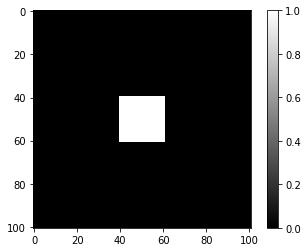

[[  1.90211303   0.61803399 -68.12749809]
 [ -0.61803399   1.90211303   0.21196876]
 [  0.           0.           1.        ]]
[[ 0.47552826 -0.1545085  32.42930147]
 [ 0.1545085   0.47552826 10.42548021]
 [ 0.          0.          1.        ]]
[[ 0.47552826 -0.1545085  32.42930147]
 [ 0.1545085   0.47552826 10.42548021]
 [ 0.          0.          1.        ]]


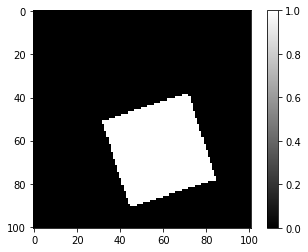

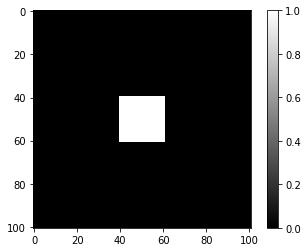

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [93]:
showG(square)
transform_test(square)

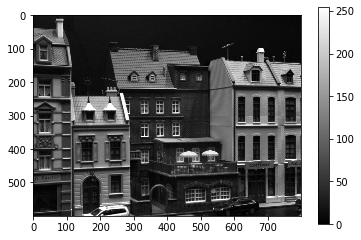

In [43]:
modelhouse = loadIm('modelhouses.png')

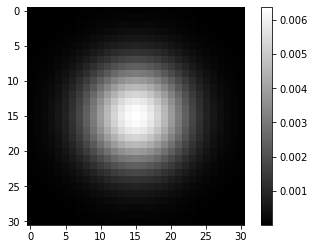

In [7]:
def gausK(sigma):
    n = 3 * sigma
    y, x = np.mgrid[-n:n+1, -n:n+1]
    H = np.exp(-(x**2 + y**2)/(2*sigma**2))
    H *= 1 / (2 * np.pi * sigma**2)
    return H
showG(gausK(5))

In [10]:
def scale_fft(img,k):
    sz = (img.shape[0] - k.shape[0], img.shape[1] - k.shape[1])
    k = np.pad(k, (((sz[0]+1)//2, sz[0]//2), ((sz[1]+1)//2,sz[1]//2)), mode='constant')
    k = ifftshift(k)
    k = fft2(k)
    fft = fft2(img)
    fft_filtered = fft * k
    f = ifft2(fft_filtered)
    return np.real(f)

In [42]:
def abs_sort(ele):
    return np.absolute(ele[3])

In [98]:
def pad_to_square(a, pad_value=0):
  m = a.reshape((a.shape[0], -1))
  padded = pad_value * np.zeros(2 * [max(m.shape)], dtype=m.dtype)
  padded[0:m.shape[0], 0:m.shape[1]] = m
  return padded


def construct_A(im, sig, k):
    im = pad_to_square(im)
    gf = gaussian_filter
    Lx = gf(im, sig, order=(0,1))
    Ly = gf(im, sig, order=(1,0))
    
    return np.array([
        [scale_fft(Lx**2,gausK(k*sig)), scale_fft(Lx*Ly,gausK(k*sig))],
        [scale_fft(Lx*Ly,gausK(k*sig)), scale_fft(Ly**2,gausK(k*sig))]
    ])

In [104]:
scale_levels = 30
scales = np.logspace(0,5,scale_levels,base=2)
k = 4
alpha = 0.05
modelhouse = modelhouse / np.max(modelhouse)
res = []

print(len(scales))

for scale in scales:
    A = construct_A(modelhouse,scale,k).T
    det = np.linalg.det(A)
    T = alpha*np.trace(A.T)**2
    R = scale**4 * (det.T - T)
    res.append(R)

extrema = []
copy = np.array(res)
z,y,x = copy.shape
zero = np.zeros((y,x))
print(copy.shape)
stack = np.pad(copy, 1, mode='constant', constant_values=(0))
print(stack.shape)
for i in range(1,z+1):
    print(f'{i}',end='\r')
    for j in range(1,y+1):
        for k in range(1,x+1):
            vs = np.delete(stack[i-1:i+2,j-1:j+2,k-1:k+2], [13])
            if(stack[i,j,k] > np.max(vs)):
                extrema.append([i,j,k, stack[i,j,k]])

30
(30, 800, 800)
(32, 802, 802)


In [ ]:
showG(copy[20])

(350, 4)


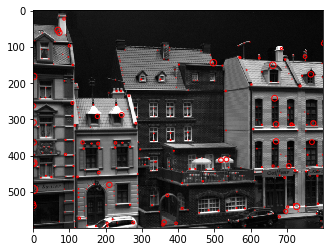

In [105]:
S = np.array(sorted(extrema, key=abs_sort)[-350:])
print(S.shape)
fig, ax = plt.subplots()
ax.imshow(modelhouse,cmap='gray')
zipped = zip(S[:,2],S[:,1],S[:,0],S[:,3])
for x,y,r,v in zipped:
    c = plt.Circle((x,y),r*0.5,color='red', fill=False)
    ax.add_patch(c)
plt.show()

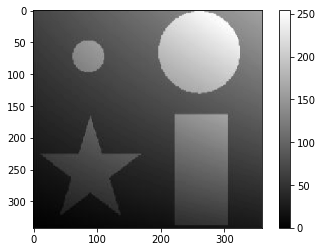

In [3]:
intens_seg = loadIm('Latex/Materials/E4/background.png')

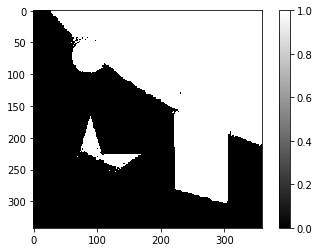

In [4]:
intens_seg_res = np.where(intens_seg > 75, 1,0)
showG(intens_seg_res)

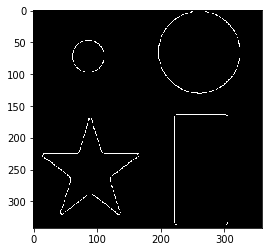

In [28]:
canny_seg_res = feature.canny(intens_seg, 3, 0,10)
plt.imshow(canny_seg_res,cmap='gray')

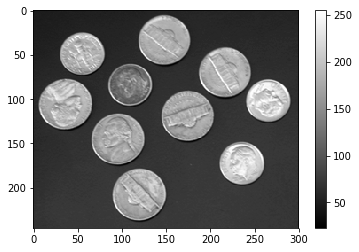

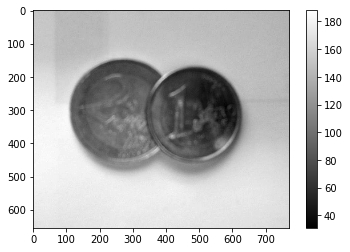

In [5]:
coins = loadIm('coins.png')
euros = loadIm('overlapping_euros.jpg')

In [68]:
def plot_hist(hist): 
    y, x = hist
    fig, ax = plt.subplots()
    ax.bar(x, y,width = 1)
    ax.set_xlabel('Pixel intensities')
    ax.set_ylabel('Probability')
    return plt.show()

def hist(arr, bins=256):
    count = np.zeros(bins)
    vals = np.arange(bins)
    for i in vals:
        count[i] = np.sum(arr == i)
    return count, vals

In [107]:
h_coins = hist(coins)
h_euros = hist(euros)

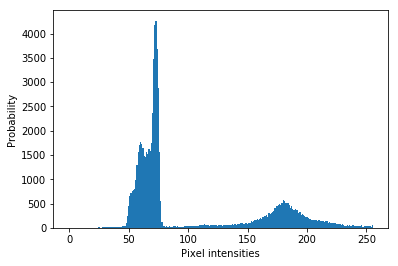

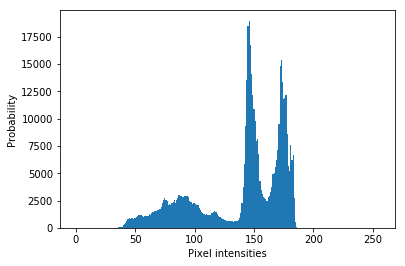

In [108]:
plot_hist(h_coins)
plot_hist(h_euros)

In [111]:
def find_peaks(im, h, thresh=0.005, width=20):
    counts, vals = h
    Y, X = im.shape
    pixels = Y*X
    peaks = []

    for i in vals:
        min_val = np.maximum(0,i-width)
        max_val = np.minimum(255,i+width)
        val = counts[i]
        val_range = counts[min_val:max_val]
        if(np.all(val >= val_range) and (val / pixels) > thresh):
            peaks.append(i)
    return peaks

In [186]:
def find_thresh(im, peaks, h):
    counts, vals = h
    num = len(peaks)
    prev = -1
    colors = np.linspace(0,num,num)
    copy = np.zeros_like(im)
    Y,X = im.shape

    for i in range(num-1):
        mean = (peaks[i] + peaks[i+1]) // 2
        min_val = np.maximum(0,mean-15)
        max_val = np.minimum(255,mean+15)
        val_range = counts[min_val:max_val]
        thresh = vals[(np.argmin(val_range) - 15) + mean]
    
        for y in range(Y):
            for x in range(X):
                if(prev < im[y,x] <= thresh):
                    copy[y,x] = colors[i]
        prev = thresh
    for y in range(Y):
        for x in range(X):
            if(prev < im[y,x] <= 255):
                copy[y,x] = colors[-1]
    return copy

In [125]:
print(find_peaks(coins, h_coins))
print(find_peaks(euros, h_euros))

[73, 180]
[87, 146, 173]


In [191]:
coins_peaks = find_peaks(coins,h_coins)
thresholds = find_thresh(coins, coins_peaks, h_coins)

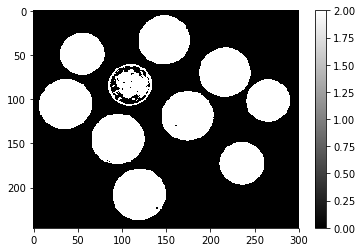

In [193]:
showG(thresholds)

In [188]:
euros_peaks = find_peaks(euros,h_euros)
thresholds = find_thresh(euros, euros_peaks, h_euros)

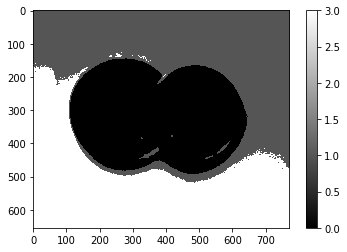

In [190]:
showG(thresholds)

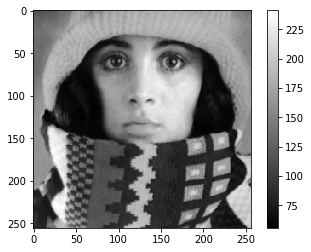

In [3]:
trui = loadIm('trui.png')
trui = trui/np.max(trui)

In [4]:
def white_noise(im,scale=0.05):
    Y,X = im.shape
    samples = np.random.normal(loc=0, scale=scale, size=Y*X)
    noise_source = samples.reshape((Y,X))
    return noise_source

In [5]:
def LSI(im,k,ns):
    return scale_fft(im,k) + ns

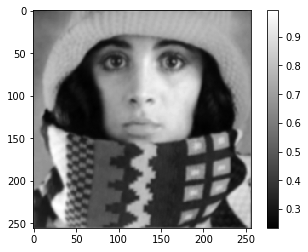

In [25]:
LSI_image = LSI(trui,gausK(1),white_noise(trui,scale=0.001))
showG(LSI_image)

In [26]:
def inverse_filtering(im,psf):
    sz = (im.shape[0] - psf.shape[0], im.shape[1] - psf.shape[1])
    psf = np.pad(psf, (((sz[0]+1)//2, sz[0]//2), ((sz[1]+1)//2,sz[1]//2)), mode='constant')
    psf = ifftshift(psf)
    psf = fft2(psf)
    fft = fft2(im)
    fft_filtered = fft / psf
    f = ifft2(fft_filtered)
    return np.real(f)

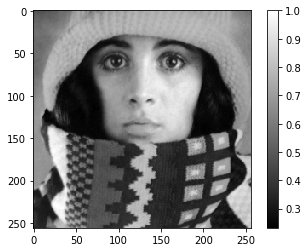

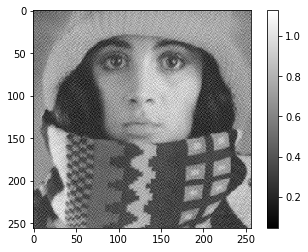

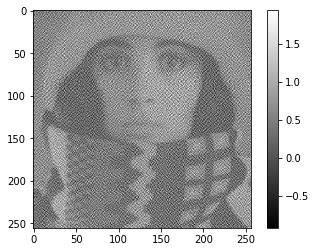

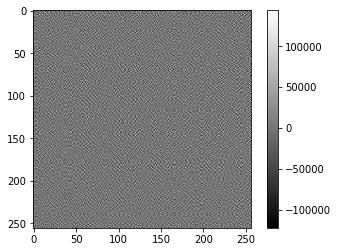

In [39]:
LSI_image_non_noise = LSI(trui,gausK(3),np.zeros_like(trui))
showG(inverse_filtering(LSI_image_non_noise,gausK(3)))
LSI_image = LSI(trui,gausK(3),white_noise(trui,scale=0.000000002))
showG(inverse_filtering(LSI_image,gausK(3)))
LSI_image = LSI(trui,gausK(3),white_noise(trui,scale=0.00000001))
showG(inverse_filtering(LSI_image,gausK(3)))
LSI_image = LSI(trui,gausK(3),white_noise(trui,scale=0.001))
showG(inverse_filtering(LSI_image,gausK(3)))

In [40]:
def wiener_filtering(im,psf,k):
    sz = (im.shape[0] - psf.shape[0], im.shape[1] - psf.shape[1])
    psf = np.pad(psf, (((sz[0]+1)//2, sz[0]//2), ((sz[1]+1)//2,sz[1]//2)), mode='constant')
    psf = ifftshift(psf)
    psf = fft2(psf)
    fft = fft2(im)
    fft_filtered = ((1/psf) * (np.abs(psf)**2 / (np.abs(psf)**2 + k))) * fft
    f = ifft2(fft_filtered)
    return np.real(f)

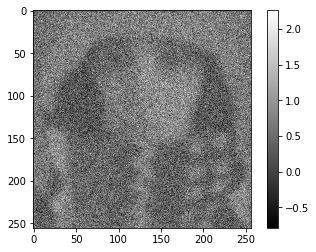

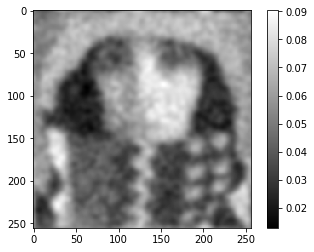

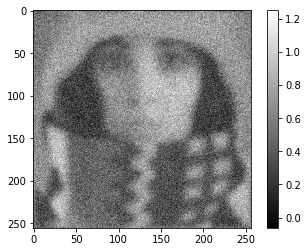

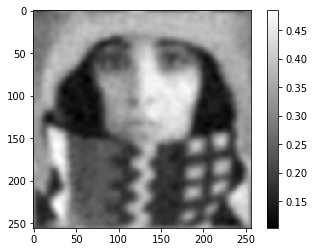

In [90]:
LSI_image = LSI(trui, gausK(3), white_noise(trui,0.3))
showG(LSI_image)
wiener_im = wiener_filtering(LSI_image,gausK(3),10)
showG(wiener_im)
LSI_image = LSI(trui, gausK(3), white_noise(trui,0.1))
showG(LSI_image)
wiener_im = wiener_filtering(LSI_image,gausK(3),1)
showG(wiener_im)

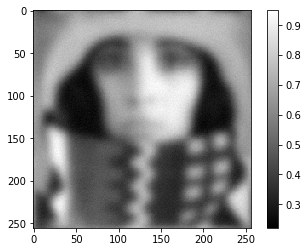

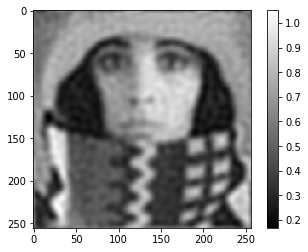

In [77]:
LSI_image = LSI(trui, gausK(5), white_noise(trui,0.01))
showG(LSI_image)
wiener_im = wiener_filtering(LSI_image,gausK(5),0.002)
showG(wiener_im)

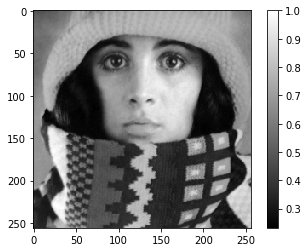

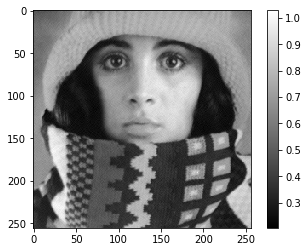

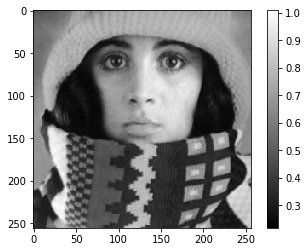

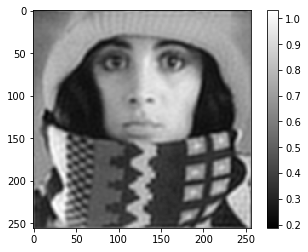

In [71]:
LSI_image_non_noise = LSI(trui,gausK(3),np.zeros_like(trui))
showG(wiener_filtering(LSI_image_non_noise,gausK(3),0))
LSI_image = LSI(trui,gausK(3),white_noise(trui,scale=0.000000002))
showG(wiener_filtering(LSI_image,gausK(3),0.000000000000001))
LSI_image = LSI(trui,gausK(3),white_noise(trui,scale=0.00000001))
showG(wiener_filtering(LSI_image,gausK(3),0.0000000000005))
LSI_image = LSI(trui,gausK(3),white_noise(trui,scale=0.001))
showG(wiener_filtering(LSI_image,gausK(3),0.0005))